In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from collections import Counter, deque

Relying on the G(N, p) model, generate with a computer three networks with N = 500 nodes and average degree (a) 〈k〉 = 0.8, (b) 〈k〉 = 1 and (c) 〈k〉 = 8. Visualize these networks

   target_avg_degree    p_used  edges  actual_avg_degree  components  \
0                0.8  0.001603    197              0.788         303   
1                1.0  0.002004    239              0.956         262   
2                8.0  0.016032   1959              7.836           1   

   largest_component_size  
0                      17  
1                      33  
2                     500  


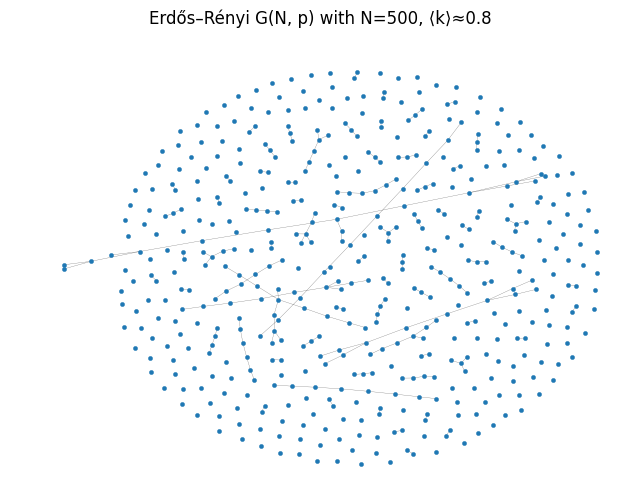

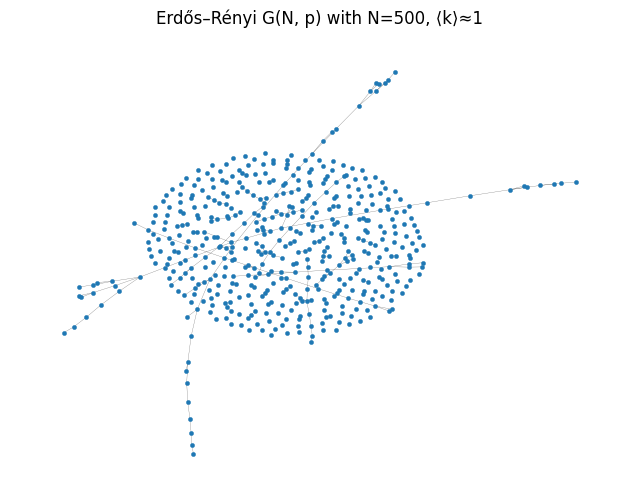

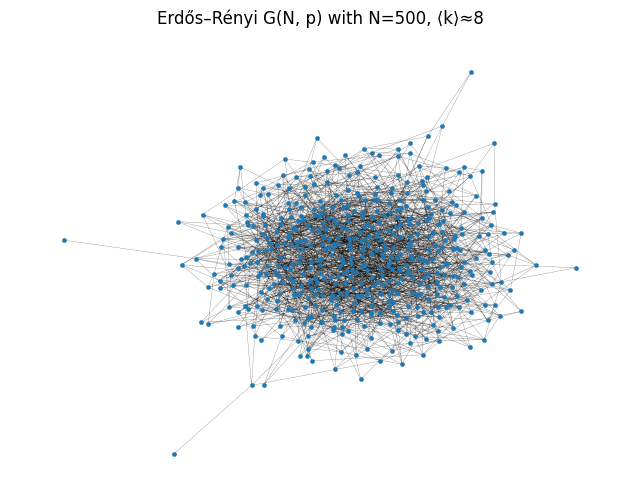

In [ ]:
N = 500
avg_degrees = [0.8, 1, 8]
ps = [k/(N-1) for k in avg_degrees]

graphs = []
for p in ps:
    G = nx.gnp_random_graph(N, p, seed=42, directed=False)
    graphs.append(G)

stats = []
for k, p, G in zip(avg_degrees, ps, graphs):
    num_edges = G.number_of_edges()
    actual_avg_degree = sum(dict(G.degree()).values())/N
    num_components = nx.number_connected_components(G)
    largest_cc = max((len(c) for c in nx.connected_components(G)), default=0)
    stats.append({
        "target_avg_degree": k,
        "p_used": p,
        "edges": num_edges,
        "actual_avg_degree": actual_avg_degree,
        "components": num_components,
        "largest_component_size": largest_cc
    })

df_stats = pd.DataFrame(stats)
print(df_stats)

node_size = 10
linewidths = 0.2
width = 0.2

for (k, G) in zip(avg_degrees, graphs):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=7, k=None)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, linewidths=linewidths)
    nx.draw_networkx_edges(G, pos, width=width, alpha=0.6)
    plt.title(f"Erdős–Rényi G(N, p) with N=500, ⟨k⟩≈{k}")
    plt.axis('off')
    plt.show()


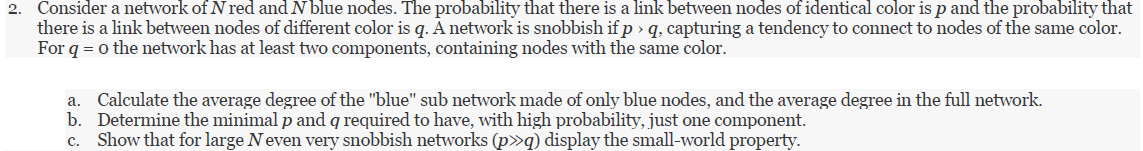

=== Example: snobbish network (p >> q) ===
 N_per_color    p      q  nodes_total  edges  avg_degree_full  avg_degree_blue_only  components  largest_cc_size  avg_shortest_path_len_giant  diameter_giant
         250 0.02 0.0001          500   1233            4.932                 4.752           5              496                     4.998558              11


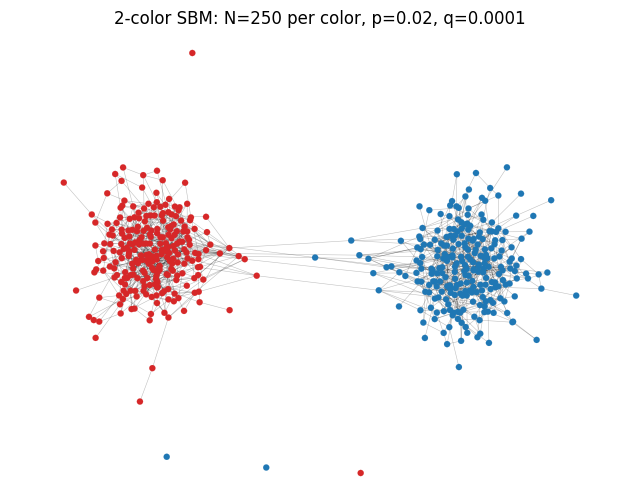

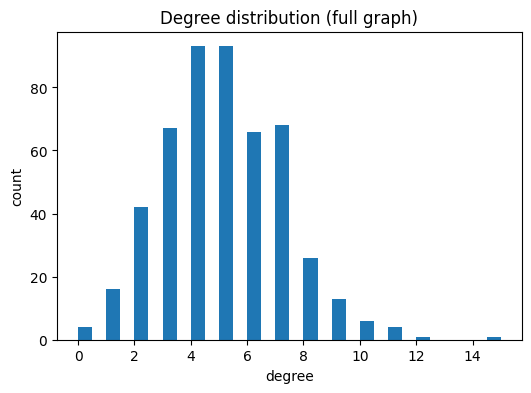


=== Example: moderate mixing (p ~ q) ===
 N_per_color    p     q  nodes_total  edges  avg_degree_full  avg_degree_blue_only  components  largest_cc_size  avg_shortest_path_len_giant  diameter_giant
         250 0.02 0.005          500   1561            6.244                 4.984           2              499                     3.601162               6


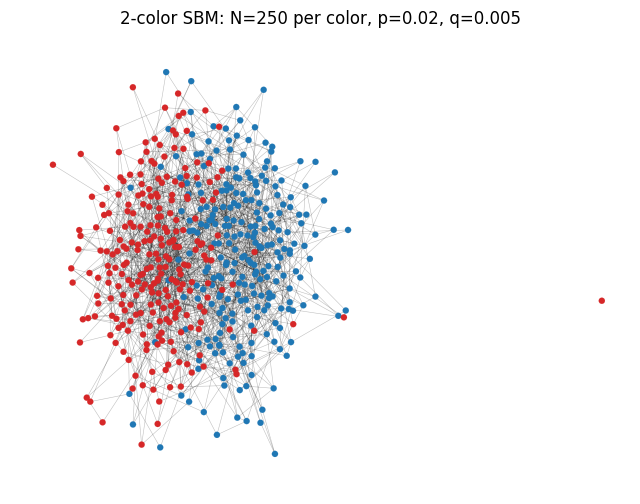

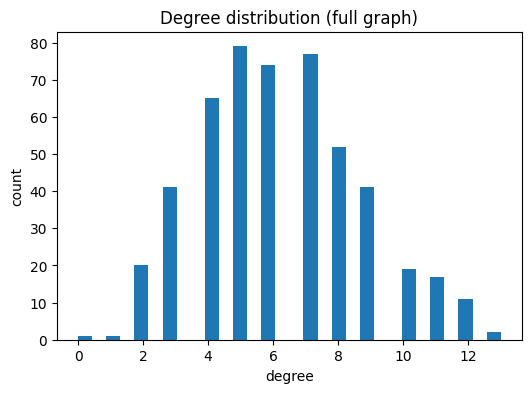


=== Quick sweep (summary) ===
    p       q  edges  avg_degree_full  avg_degree_blue_only  components  largest_cc_size  avg_shortest_path_len_giant
0.001 0.00000   11.0             0.11                  0.08       189.0              2.0                     1.000000
0.001 0.00001   11.0             0.11                  0.06       189.0              2.0                     1.000000
0.001 0.00010    9.0             0.09                  0.08       191.0              3.0                     1.333333
0.005 0.00000   58.0             0.58                  0.54       142.0              6.0                     2.066667
0.005 0.00001   41.0             0.41                  0.48       159.0              5.0                     1.800000
0.005 0.00010   53.0             0.53                  0.42       147.0              9.0                     3.055556
0.010 0.00000  105.0             1.05                  1.00        95.0             18.0                     4.339869
0.010 0.00001   96.0     

In [ ]:
def generate_two_color_sbm(N, p, q, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    G = nx.Graph()
    G.add_nodes_from(range(2*N))
    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() < p:
                G.add_edge(i, j)
    for i in range(N, 2*N):
        for j in range(i+1, 2*N):
            if np.random.rand() < p:
                G.add_edge(i, j)
    for i in range(N):
        for j in range(N, 2*N):
            if np.random.rand() < q:
                G.add_edge(i, j)
    return G

def analyze_graph(G, N):
    total_nodes = 2*N
    edges = G.number_of_edges()
    degs = dict(G.degree())
    avg_full = sum(degs.values())/total_nodes
    blue_nodes = list(range(N))
    G_blue = G.subgraph(blue_nodes)
    degs_blue = dict(G_blue.degree())
    avg_blue_only = sum(degs_blue.values())/N
    num_components = nx.number_connected_components(G)
    cc_sizes = sorted((len(c) for c in nx.connected_components(G)), reverse=True)
    largest_cc = cc_sizes[0] if cc_sizes else 0
    stats = {
        "nodes_total": total_nodes,
        "edges": edges,
        "avg_degree_full": avg_full,
        "avg_degree_blue_only": avg_blue_only,
        "components": num_components,
        "largest_cc_size": largest_cc
    }
    if largest_cc > 1:
        giant_nodes = max(nx.connected_components(G), key=len)
        Gg = G.subgraph(giant_nodes)
        try:
            avg_spl = nx.average_shortest_path_length(Gg)
            diam = nx.diameter(Gg)
        except Exception as e:
            avg_spl = np.nan
            diam = np.nan
        stats["avg_shortest_path_len_giant"] = avg_spl
        stats["diameter_giant"] = diam
    else:
        stats["avg_shortest_path_len_giant"] = np.nan
        stats["diameter_giant"] = np.nan
    return stats

def single_run_example(N=250, p=0.02, q=0.005, seed=42, draw=True):
    G = generate_two_color_sbm(N, p, q, seed=seed)
    stats = analyze_graph(G, N)
    df = pd.DataFrame([{
        "N_per_color": N,
        "p": p,
        "q": q,
        **stats
    }])
    print(df.to_string(index=False))
    if draw:
        pos = nx.spring_layout(G, seed=7)
        color_map = ["tab:blue" if i < N else "tab:red" for i in G.nodes()]
        plt.figure(figsize=(8,6))
        nx.draw_networkx_nodes(G, pos, node_size=20, node_color=color_map, linewidths=0.1)
        nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.4)
        plt.title(f"2-color SBM: N={N} per color, p={p}, q={q}")
        plt.axis("off")
        plt.show()
        degs = [d for n,d in G.degree()]
        plt.figure(figsize=(6,4))
        plt.hist(degs, bins=30)
        plt.title("Degree distribution (full graph)")
        plt.xlabel("degree")
        plt.ylabel("count")
        plt.show()
    return G, df, stats

def sweep_p_q(N=250, p_list=None, q_list=None, trials=3, seed=123):
    if p_list is None:
        p_list = [0.005, 0.01, 0.02, 0.04, 0.08]
    if q_list is None:
        q_list = [0.0, 1e-5, 1e-4, 1e-3, 0.005]
    rows = []
    run_id = 0
    rng = np.random.RandomState(seed)
    for p in p_list:
        for q in q_list:
            for t in range(trials):
                run_seed = int(rng.randint(0, 2**30))
                G = generate_two_color_sbm(N, p, q, seed=run_seed)
                s = analyze_graph(G, N)
                rows.append({
                    "run": run_id,
                    "N_per_color": N,
                    "p": p,
                    "q": q,
                    **s
                })
                run_id += 1
    df = pd.DataFrame(rows)
    agg = df.groupby(["p","q"]).agg({
        "edges":"mean",
        "avg_degree_full":"mean",
        "avg_degree_blue_only":"mean",
        "components":"mean",
        "largest_cc_size":"mean",
        "avg_shortest_path_len_giant":"mean"
    }).reset_index()
    return df, agg

print("=== Example: snobbish network (p >> q) ===")
G1, df1, stats1 = single_run_example(N=250, p=0.02, q=0.0001, seed=42, draw=True)

print("\n=== Example: moderate mixing (p ~ q) ===")
G2, df2, stats2 = single_run_example(N=250, p=0.02, q=0.005, seed=2023, draw=True)

print("\n=== Quick sweep (summary) ===")
df_runs, df_agg = sweep_p_q(N=100,
                           p_list=[0.001, 0.005, 0.01],
                           q_list=[0.0, 1e-5, 1e-4],
                           trials=1, seed=7)
print(df_agg.to_string(index=False))


Write a computer code to generate networks of size N with a power-law degree distribution with degree exponent γ. Generate three networks with γ = 2.2 and with N = 103, N = 104 and N = 105 nodes, respectively. What is the percentage of multi-link and selfloops in each network? Generate more networks to plot this percentage in function of N. Do the same for networks with γ = 3.

     N  gamma  perc_selfloops  perc_multiedges
  1000    2.2        2.022672        18.292954
 10000    2.2        1.562811        17.499502
100000    2.2        0.733263        12.004035
  1000    3.0        0.119617         0.179426
 10000    3.0        0.042258         0.066405
100000    3.0        0.006690         0.017638


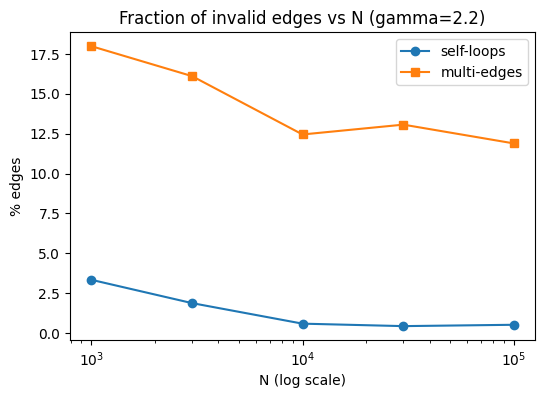

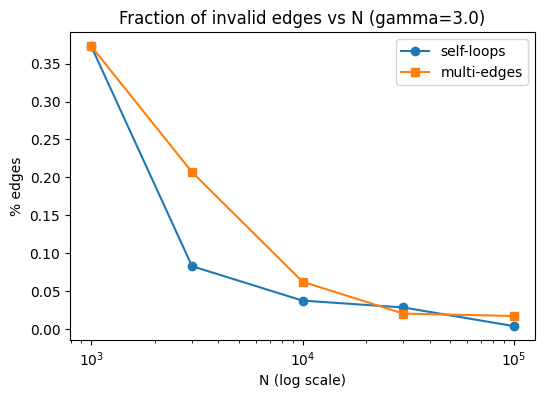

In [ ]:
def generate_powerlaw_config(N, gamma, kmin=1, seed=None):
    rng = np.random.default_rng(seed)
    degrees = []
    while len(degrees) < N:
        k = int(np.floor((1-rng.random())**(-1/(gamma-1))))
        if k >= kmin:
            degrees.append(k)

    if sum(degrees) % 2 != 0:
        degrees[rng.integers(N)] += 1
    G = nx.configuration_model(degrees, seed=seed)
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G, degrees

def count_multiedges_selfloops(N, gamma, trials=3, seed=42):
    rng = np.random.default_rng(seed)
    total_self = 0
    total_multi = 0
    total_edges = 0
    for t in range(trials):
        rng_seed = int(rng.integers(0, 1e9))
        degs = []
        while len(degs) < N:
            k = int(np.floor((1-rng.random())**(-1/(gamma-1))))
            if k >= 1:
                degs.append(k)
        # Ensure the sum of degrees is even
        if sum(degs) % 2 != 0:
            degs[rng.integers(N)] += 1

        Gmulti = nx.configuration_model(degs, seed=rng_seed)
        edges = list(Gmulti.edges())
        total_edges += len(edges)
        selfloops = sum(1 for u,v in edges if u==v)
        total_self += selfloops
        seen = set()
        multi = 0
        for u,v in edges:
            if u>v: u,v=v,u
            if (u,v) in seen:
                multi += 1
            else:
                seen.add((u,v))
        total_multi += multi
    return {
        "N": N,
        "gamma": gamma,
        "perc_selfloops": 100*total_self/total_edges if total_edges>0 else 0,
        "perc_multiedges": 100*total_multi/total_edges if total_edges>0 else 0
    }

results = []
for gamma in [2.2, 3.0]:
    for N in [10**3, 10**4, 10**5]:
        res = count_multiedges_selfloops(N, gamma, trials=2, seed=42)
        results.append(res)

df = pd.DataFrame(results)
print(df.to_string(index=False))

Ns = [10**3, 3*10**3, 10**4, 3*10**4, 10**5]
plot_data = []
for gamma in [2.2, 3.0]:
    for N in Ns:
        res = count_multiedges_selfloops(N, gamma, trials=1, seed=123)
        plot_data.append(res)
df_plot = pd.DataFrame(plot_data)

for gamma in [2.2, 3.0]:
    df_g = df_plot[df_plot.gamma==gamma]
    plt.figure(figsize=(6,4))
    plt.plot(df_g.N, df_g.perc_selfloops, marker="o", label="self-loops")
    plt.plot(df_g.N, df_g.perc_multiedges, marker="s", label="multi-edges")
    plt.xscale("log")
    plt.xlabel("N (log scale)")
    plt.ylabel("% edges")
    plt.title(f"Fraction of invalid edges vs N (gamma={gamma})")
    plt.legend()
    plt.show()

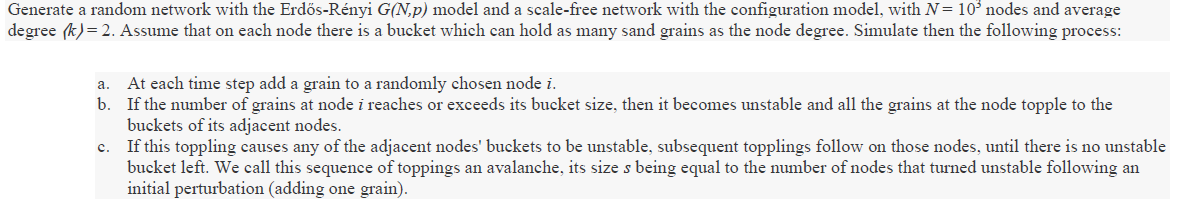

ER: N, M, avg_k: 1000 999 1.998
CONFIG (after simplifying): avg_k (desired approx 2.0) = 2.06
Simulating avalanches on ER...


/tmp/ipython-input-4146798864.py:109: RuntimeWarning: overflow encountered in scalar add
  grains[v] += grains_to_move


Done ER. mean avalanche size: 17.401 non-zero avalanches: 1855
Simulating avalanches on configuration model...
Done CONF. mean avalanche size: 67.13266666666667 non-zero avalanches: 2173
--- ER ---
count: 1855
mean: 28.14177897574124
median: 2.0
max: 802
 s=1: 895
 s=2: 217
 s=3: 99
 s=4: 82
 s=5: 43

--- Config ---
count: 2173
mean: 92.68200644270594
median: 2.0
max: 685
 s=1: 554
 s=2: 816
 s=3: 154
 s=4: 97
 s=5: 20



{'ER': {'avalanches': array([0, 1, 0, ..., 2, 1, 1]),
  'grains': array([-3610617255456261891,                    0, -2441581768023190776,
                            0,  2698045723931145526,  1179420857898019985,
                            0,                    0, -8289509062437157863,
          7953460971508871340,                    0,  4692843344941665370,
                            0, -3097393613127859870,                    0,
                            0,                    0, -1701214162742548380,
         -9139798927345133785,                    4,  1271489038686428905,
         -7651539791418795001,  8070164746119948972,               122376,
                            0,                    0,                    0,
          -820919078417955317,  6273329638271608859,                    0,
         -6870175130780575166,                    0,                    0,
          3957586423048135071,                    0, -2858203611190807925,
                            0, -6528

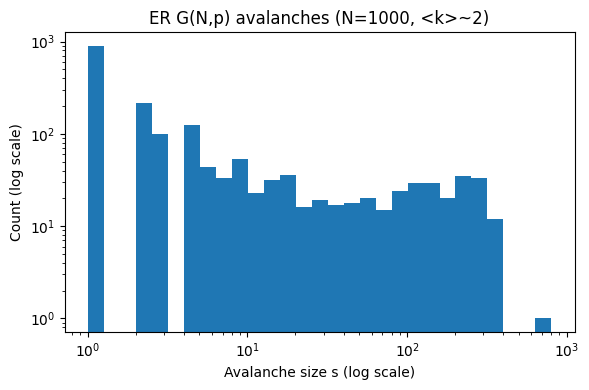

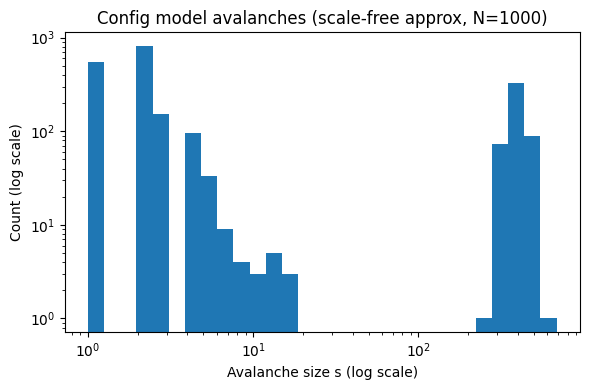

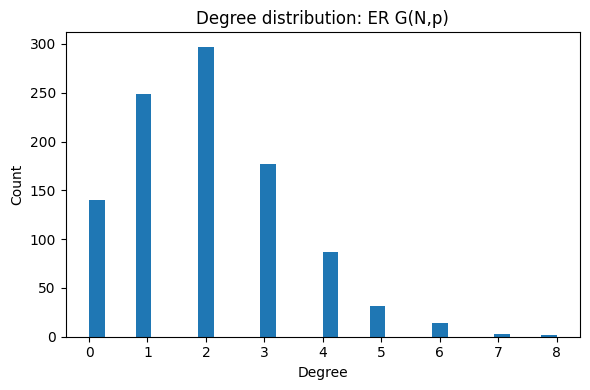

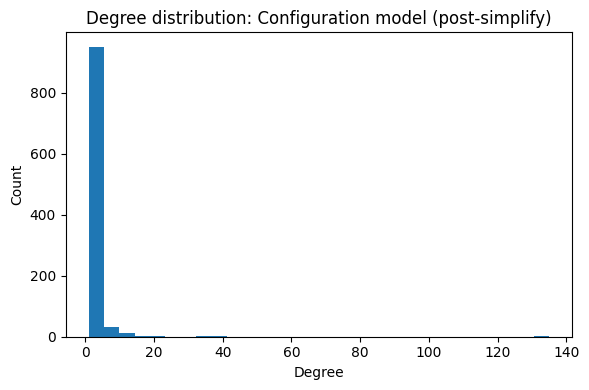

In [ ]:
# Parameters (adjustable)
N = 1000
target_avg_k = 2.0
p_er = target_avg_k / (N - 1)
gamma_sf = 2.5         # exponent for power-law degree sampling (used to create SF degree sequence)
kmax_sf = 100          # cutoff for sampled degrees
steps = 12000          # total grain additions simulated
burn_in = 2000         # don't record avalanches during burn-in
seed = 42

rng = np.random.default_rng(seed)

# 1) ER network
G_er = nx.fast_gnp_random_graph(N, p_er, seed=seed+1)

# 2) scale-free degree sequence (discrete approximate power law) and configuration model
def generate_powerlaw_degrees(N, gamma=2.5, kmin=1, kmax=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    degs = []
    a = kmin**(1-gamma)
    b = kmax**(1-gamma)
    while len(degs) < N:
        r = rng.random()
        k = int((a + (b-a)*r)**(1/(1-gamma)))
        if k < kmin:
            k = kmin
        if k > kmax:
            k = kmax
        degs.append(k)
    if sum(degs) % 2 == 1:
        degs[0] += 1
    return degs

degs_sf = generate_powerlaw_degrees(N, gamma=gamma_sf, kmin=1, kmax=kmax_sf, rng=rng)

# Adjust average degree toward target by decrementing some degrees >1 if needed
cur_avg = sum(degs_sf)/N
if cur_avg > target_avg_k:
    excess = int(round((cur_avg - target_avg_k) * N))
    idxs = [i for i,d in enumerate(degs_sf) if d>1]
    while excess>0 and idxs:
        i = rng.choice(idxs)
        degs_sf[i] -= 1
        if degs_sf[i] <= 1:
            idxs.remove(i)
        excess -= 1
if sum(degs_sf) % 2 == 1:
    degs_sf[0] += 1

G_sf_multi = nx.configuration_model(degs_sf, seed=seed+2)
G_sf = nx.Graph(G_sf_multi)
G_sf.remove_edges_from(nx.selfloop_edges(G_sf))

# Utility: build arrays for simulation
def prepare_graph_arrays(G):
    N = G.number_of_nodes()
    deg = np.array([d for _,d in G.degree()], dtype=int)
    neighbors = [list(G.adj[n]) for n in range(N)]
    return deg, neighbors

deg_er, neigh_er = prepare_graph_arrays(G_er)
deg_sf, neigh_sf = prepare_graph_arrays(G_sf)

# Fast sandpile simulation (Abelian rule: threshold = degree, topple sends 1 grain to each neighbor)
def simulate_sandpile_fast(deg, neigh, steps=10000, burn_in=1000, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    N = len(deg)
    grains = np.zeros(N, dtype=np.int32)
    avalanches = []
    neighbors = neigh
    degree = deg
    # queue bookkeeping optimized: use deque and in_queue boolean array
    for t in range(steps):
        i = int(rng.integers(0, N))
        grains[i] += 1
        q = deque()
        in_q = np.zeros(N, dtype=bool)
        if degree[i] > 0 and grains[i] >= degree[i]:
            q.append(i); in_q[i] = True
        toppled_set = set()
        while q:
            v = q.popleft(); in_q[v] = False
            # confirm still unstable
            if degree[v] == 0:
                continue
            if grains[v] >= degree[v]:
                grains[v] -= degree[v]
                for nb in neighbors[v]:
                    grains[nb] += 1
                    if degree[nb] > 0 and grains[nb] >= degree[nb] and not in_q[nb]:
                        q.append(nb); in_q[nb] = True
                toppled_set.add(v)
        s = len(toppled_set)
        if t >= burn_in:
            avalanches.append(s)
    return np.array(avalanches), grains

# Run (use different RNG seeds for the two models)
av_er, grains_er = simulate_sandpile_fast(deg_er, neigh_er, steps=steps, burn_in=burn_in, rng_seed=seed+10)
av_sf, grains_sf = simulate_sandpile_fast(deg_sf, neigh_sf, steps=steps, burn_in=burn_in, rng_seed=seed+20)

# Analyze and plot avalanche size distributions
def plot_avalanche_distribution(av, title_prefix):
    counts = Counter(av)
    counts.pop(0, None)  # remove zero-size events (no toppling)
    if len(counts)==0:
        print(title_prefix, "no avalanches recorded (all zeros).")
        return {}
    sizes = np.array(sorted(counts.keys()))
    freqs = np.array([counts[s] for s in sizes], dtype=float)
    probs = freqs / freqs.sum()
    plt.figure(figsize=(6,4))
    plt.loglog(sizes, probs, marker='o', linestyle='none')
    plt.xlabel("avalanche size s")
    plt.ylabel("P(s)")
    plt.title(f"{title_prefix} avalanche size distribution")
    plt.show()
    # CCDF
    all_sizes = np.array(list(counts.elements()))
    sorted_sizes = np.sort(all_sizes)
    ks = np.unique(sorted_sizes)
    ccdf = np.array([np.sum(sorted_sizes >= k) for k in ks]) / len(sorted_sizes)
    plt.figure(figsize=(6,4))
    plt.loglog(ks, ccdf, marker='o', linestyle='none')
    plt.xlabel("s")
    plt.ylabel("P(S ≥ s)")
    plt.title(f"{title_prefix} avalanche CCDF")
    plt.show()
    return {"count_events": len(all_sizes), "mean_s": all_sizes.mean(), "median_s": np.median(all_sizes), "max_s": all_sizes.max()}

res_er = plot_avalanche_distribution(av_er, "Erdos-Renyi G(N,p)")
res_sf = plot_avalanche_distribution(av_sf, "Scale-free (configuration model)")

# Combined CCDF plot
def ccdf_from_samples(samples):
    s = samples[samples>0]
    if len(s)==0:
        return np.array([0]), np.array([0])
    ks = np.unique(s)
    ccdf = np.array([np.sum(s >= k) for k in ks]) / len(s)
    return ks, ccdf

ks_er, ccdf_er = ccdf_from_samples(av_er)
ks_sf, ccdf_sf = ccdf_from_samples(av_sf)

plt.figure(figsize=(6,4))
plt.loglog(ks_er, ccdf_er, marker='o', linestyle='none', label='ER')
plt.loglog(ks_sf, ccdf_sf, marker='s', linestyle='none', label='SF')
plt.xlabel("s")
plt.ylabel("P(S ≥ s)")
plt.title("Avalanche CCDF: ER vs SF")
plt.legend()
plt.show()

# Save summary
df_out = pd.DataFrame([
    {"model":"ER","N":N,"avg_degree":sum(dict(G_er.degree()).values())/N, **res_er},
    {"model":"SF","N":N,"avg_degree":sum(dict(G_sf.degree()).values())/N, **res_sf}
])
df_out.to_csv("sandpile_avalanche_summary.csv", index=False)
print("Saved summary to sandpile_avalanche_summary.csv")
print(df_out.to_string(index=False))
